# Model comparison using bootstrap and permutation tests

**ELEC-E8739 - AI in health technologies**

<div>
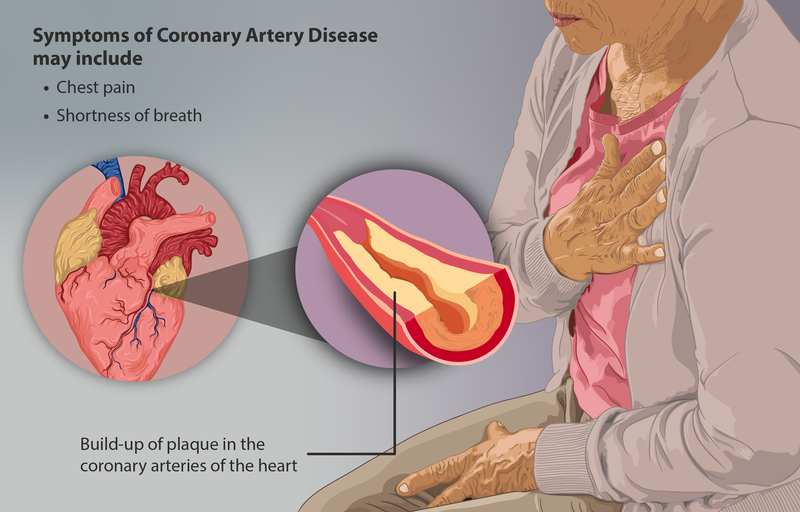
</div>

**Overview**
This tutorial compares a Decision Tree classifier and a Gradient Boosting classifier on the Coronary Artery Disease dataset using permutation and bootstrap tests.

**Objectives**

1. Understand model comparison and statistical significance.
2. Understand the challenge of using permutation test for model comparison.
3. Implement permutation and bootstrap tests to compare model performance.



(c) Prof. Aleksei Tiulpin, PhD

## Imports and utility functions

In [1]:
import numpy as np

import numpy as np
import random
import matplotlib.pyplot as plt
import pathlib

from sklearn.metrics import average_precision_score, roc_auc_score, roc_curve, precision_recall_curve, balanced_accuracy_score, accuracy_score

from ucimlrepo import fetch_ucirepo 
from scipy import stats
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler

SEED = 42

np.random.seed(SEED)

pathlib.Path("model_selection").mkdir(exist_ok=True)

def plot_report(prob_1, prob_2, gt, save_path_auc, save_path_ap):
    plt.figure(figsize=(3.5, 3.5), dpi=150)
    plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), '--', c='black')
    fpr, tpr, _ = roc_curve(gt, prob_1)
    plt.plot(fpr, tpr, 'b-')    
    fpr, tpr, _ = roc_curve(gt, prob_2)
    plt.plot(fpr, tpr, 'r')
    plt.grid()
    plt.xlabel('FPR (1-Specificity)', fontsize=16)
    plt.ylabel('TPR (Sensitivity)', fontsize=16)
    plt.tight_layout()
    if save_path_auc is not None:
        plt.savefig(save_path_auc,  bbox_inches="tight")
    plt.show()

    plt.figure(figsize=(3.5, 3.5), dpi=150)
    precision, recall, _ = precision_recall_curve(gt, prob_1)
    plt.plot(recall, precision, 'b')
    precision, recall, _ = precision_recall_curve(gt, prob_2)
    plt.plot(recall, precision, 'r')
    plt.grid()
    plt.xlabel('Recall (TPR)', fontsize=16)
    plt.ylabel('Precision (PPV)', fontsize=16)
    plt.axhline(y=gt.sum() / gt.shape[0], color='black', linestyle='--')
    plt.tight_layout()
    if save_path_ap is not None:
        plt.savefig(save_path_ap, bbox_inches="tight")
    plt.show()


## Loading the data and training two models

* Model 1: KNN
* Model 2: Gradient Boosting Machine

In [2]:
heart_disease = fetch_ucirepo(id=45) 
  
# data (as pandas dataframes) 
X = heart_disease.data.features 
y = heart_disease.data.targets 


In [3]:
na_s = X.isna().any(axis=1)

X = X.loc[~na_s].values
y = 1*(y.loc[~na_s].values.squeeze() > 0)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=SEED)

In [5]:
print("Train size: ", X_train.shape[0])
print("Test size: ", X_test.shape[0])

Train size:  207
Test size:  90


In [6]:
cls_1 = KNeighborsClassifier(n_neighbors=15)
cls_1.fit(X_train, y_train)
probs_1 = cls_1.predict_proba(X_test)[:, 1]


cls_2 =  GradientBoostingClassifier(n_estimators=100, random_state=SEED)
cls_2.fit(X_train, y_train)
probs_2 = cls_2.predict_proba(X_test)[:, 1]

In [7]:
## Visualization

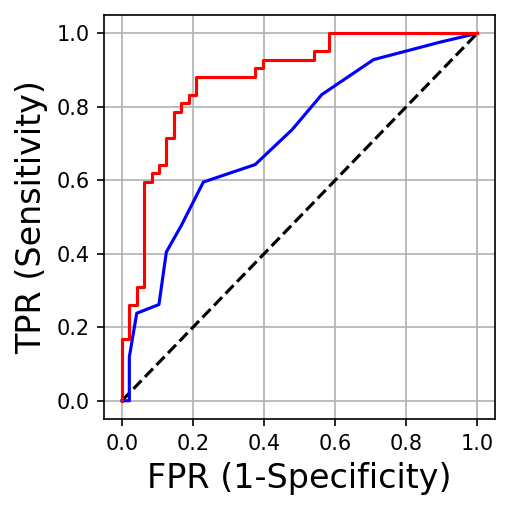

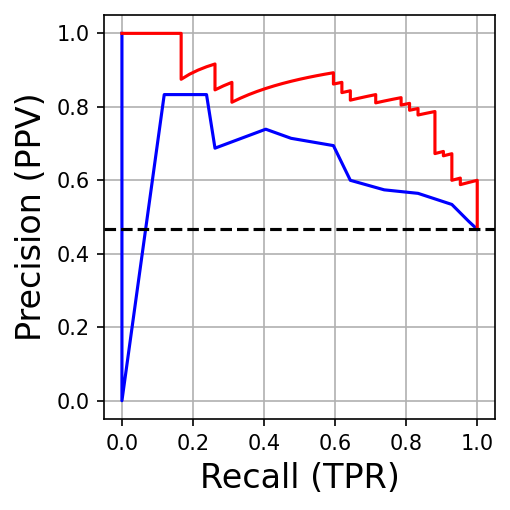

AUC: 0.72 vs 0.88
AP: 0.68 vs 0.85


In [8]:
plot_report(probs_1, probs_2, y_test, "cad_roc.pdf", "cad_prerec.pdf")

# Test statistic is the difference between of the metrics
auc_emp_2 = roc_auc_score(y_test, probs_2)
auc_emp_1 = roc_auc_score(y_test, probs_1)

ap_emp_2 = average_precision_score(y_test, probs_2)
ap_emp_1 = average_precision_score(y_test, probs_1)

auc_diff_emp  = auc_emp_2 - auc_emp_1
ap_diff_emp = ap_emp_2 - ap_emp_1

print(f"AUC: {auc_emp_1:.2f} vs {auc_emp_2:.2f}")
print(f"AP: {ap_emp_1:.2f} vs {ap_emp_2:.2f}")

Permuting: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 738.91it/s]


== AUC ==


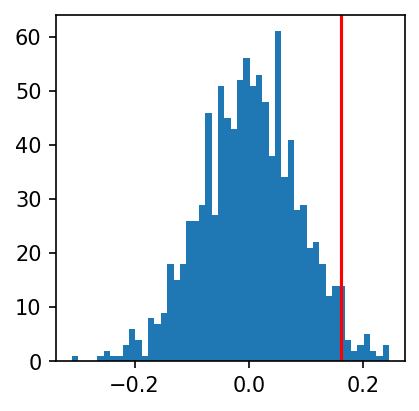

P-val, AUC:  0.027


== AP ==


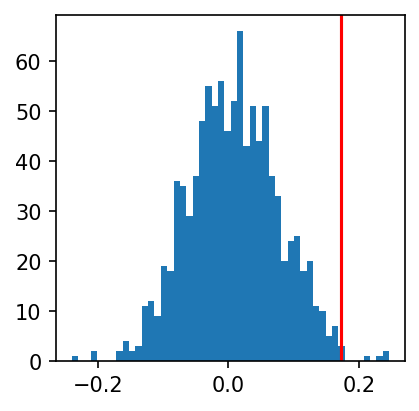

P-val, AP:  0.007


In [9]:
np.random.seed(SEED)
n_permutations = 1000

auc_array = []
ap_array = []

# Setting up the test
n_samples = y_test.shape[0]
combined_preds = np.hstack((probs_1, probs_2))

for i in tqdm(range(n_permutations), total=n_permutations, desc="Permuting"):
    ind = np.random.choice(n_samples, n_samples, replace=False)
    shuffled_preds_1 = probs_1[ind]

    ind = np.random.choice(n_samples, n_samples, replace=False)
    shuffled_preds_2 = probs_2[ind]
    
    auc_1 = roc_auc_score(y_test, shuffled_preds_1)
    auc_2 = roc_auc_score(y_test, shuffled_preds_2)

    ap_1 = average_precision_score(y_test, shuffled_preds_1)
    ap_2 = average_precision_score(y_test, shuffled_preds_2)

    auc_array.append(auc_2 - auc_1)
    ap_array.append(ap_2 - ap_1)


print("== AUC ==")
plt.figure(figsize=(3, 3), dpi=150)
plt.hist(auc_array, bins=50)
plt.axvline(auc_diff_emp, color='red')
plt.show()
pval = np.mean(np.array(auc_array) > auc_diff_emp)
print("P-val, AUC: ", pval)
print("")

print("")
print("== AP ==")
plt.figure(figsize=(3, 3), dpi=150)
plt.hist(ap_array, bins=50)
plt.axvline(ap_diff_emp, color='red')
plt.show()
pval = np.mean(np.array(ap_array) > ap_diff_emp)
print("P-val, AP: ", pval)

## Bootstrap 95% confidence intervals

Instead of doing a permutation test, we should do a bootstrap here.

In [10]:
np.random.seed(SEED)

alpha = 95
n_bootstrap = 1000
auc_array = []
ap_array = []

for _ in tqdm(range(n_bootstrap), total=n_bootstrap, desc="Bootstrapping"):
    ind = np.random.choice(y_test.shape[0], y_test.shape[0], replace=True)

    auc_1 = roc_auc_score(y_test[ind], probs_1[ind])
    auc_2 = roc_auc_score(y_test[ind], probs_2[ind])

    ap_1 = average_precision_score(y_test[ind], probs_1[ind])
    ap_2 = average_precision_score(y_test[ind], probs_2[ind])

    auc_array.append((auc_1, auc_2))
    ap_array.append((ap_1, ap_2))

# We store bootstrap distribution here as numpy arrays for a more convenient indexing
auc_array = np.array(auc_array)
ap_array = np.array(ap_array)

auc_1_ci_l = np.percentile(auc_array[:, 0], (100 - alpha) // 2)
auc_1_ci_h = np.percentile(auc_array[:, 0], alpha + (100 - alpha) // 2)

auc_2_ci_l = np.percentile(auc_array[:, 1], (100 - alpha) // 2)
auc_2_ci_h = np.percentile(auc_array[:, 1], alpha + (100 - alpha) // 2)

ap_1_ci_l = np.percentile(auc_array[:, 0], (100 - alpha) // 2)
ap_1_ci_h = np.percentile(auc_array[:, 0], alpha + (100 - alpha) // 2)

ap_2_ci_l = np.percentile(auc_array[:, 1], (100 - alpha) // 2)
ap_2_ci_h = np.percentile(auc_array[:, 1], alpha + (100 - alpha) // 2)

Bootstrapping: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 678.85it/s]


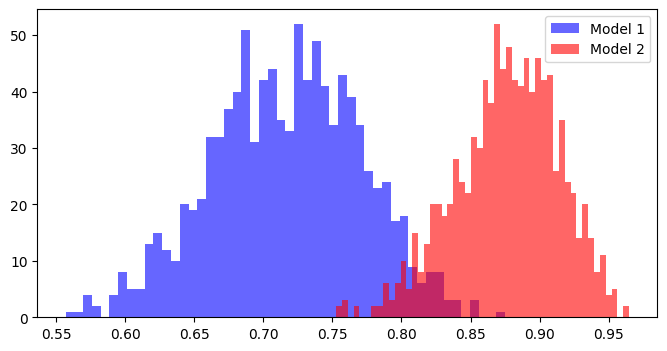

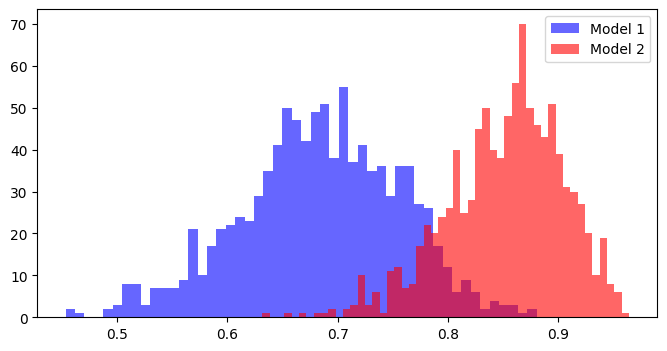

In [11]:
plt.figure(figsize=(8, 4))
#plt.title("Bootstrapped AUC distribution")
plt.hist(auc_array[:, 0], bins=50, alpha=0.6, label='Model 1', color='b')
plt.hist(auc_array[:, 1], bins=50, alpha=0.6, label='Model 2', color='r')
plt.legend()
plt.savefig("model_selection/auc.pdf", bbox_inches="tight")
plt.show()

plt.figure(figsize=(8, 4))
#plt.title("Bootstrap AP distribution")
plt.hist(ap_array[:, 0], bins=50, alpha=0.6, label='Model 1', color='b')
plt.hist(ap_array[:, 1], bins=50, alpha=0.6, label='Model 2', color='r')
plt.legend()
plt.savefig("model_selection/ap.pdf", bbox_inches="tight")
plt.show()

In [12]:
print(f"AUC [model 1] {auc_emp_1:.2f} [{auc_1_ci_l:.2f}-{auc_1_ci_h:.2f}]")

AUC [model 1] 0.72 [0.60-0.81]


In [13]:
print(f"AUC [model 2] {auc_emp_2:.2f} [{auc_2_ci_l:.2f}-{auc_2_ci_h:.2f}]")

AUC [model 2] 0.88 [0.80-0.94]


## Bootstrap testing

The main idea is to test whether the observed (indexed by `emp`) emprical difference is legit. We thus define the following null-hypothesis:

$H_0: AUC_2 - AUC_1 = 0$

$H_1: AUC_2 - AUC_1 \geq 0$.

our statistic is $T = AUC_2 - AUC_1$. To compute the p-value, we estimate:

$$p= \frac{1 + \sum_{i=1}^B(T_i >= T_{obs})}{B + 1}$$


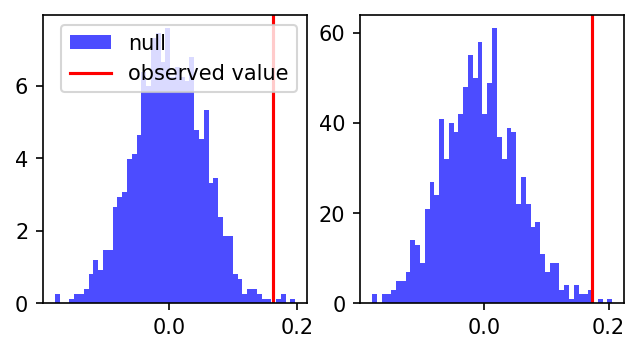

P-value: 0.0070
P-value: 0.0070


In [14]:
plt.figure(figsize=(5, 2.5), dpi=150)
plt.subplot(121)

null_distribution = auc_array[:, 1] - auc_array[:, 0] - auc_diff_emp
plt.hist(null_distribution, bins=50, color='blue', alpha=0.7, label="null", density=True,)
plt.axvline(auc_diff_emp, color='red', label="observed value")
plt.legend()
plt.savefig("model_selection/auc_sd.pdf", bbox_inches="tight")
plt.subplot(122)

null_distribution = ap_array[:, 1] - ap_array[:, 0] - ap_diff_emp
plt.hist(null_distribution, bins=50, color="blue", alpha=0.7, label="null")
plt.axvline(ap_diff_emp, color='red', label="observed")
#plt.legend()
plt.savefig("model_selection/ap_sd.pdf", bbox_inches="tight")
plt.show()

p_auc = (1 + np.sum(null_distribution >= auc_diff_emp)) / null_distribution.shape[0]
print(f"P-value: {p_auc:.4f}")

p_ap = (1 + np.sum(null_distribution >= ap_diff_emp)) / null_distribution.shape[0]
print(f"P-value: {p_auc:.4f}")